# Semi-classical light-matter interaction with QuTip

## Two-level atom with QuTip (time-independent H)

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from qutip import *
import time as time

In [2]:
# define some Hamiltonian
Rabi_freq = 2*np.pi*20 # 1/s
H = Rabi_freq/2 * sigmax()
print(H)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.         62.83185307]
 [62.83185307  0.        ]]


In [3]:
ket_g = basis(2, 0)
ket_e = basis(2,1)
bra_g = ket_g.dag()
bra_e = ket_e.dag()

print(ket_g)
print(ket_e)
print(bra_g)
print(bra_e)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]
Quantum object: dims = [[1], [2]], shape = (1, 2), type = bra
Qobj data =
[[1. 0.]]
Quantum object: dims = [[1], [2]], shape = (1, 2), type = bra
Qobj data =
[[0. 1.]]


In [4]:
# define the observable I care about
sigma_ee = ket_e * bra_e
print(sigma_ee)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]


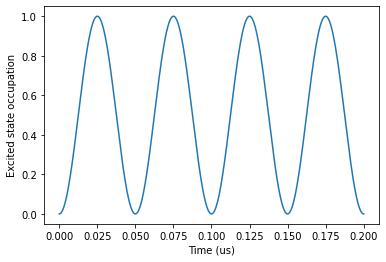

In [5]:
# Consider coherent evolution from t = 0-10 (Rabi flopping)
t = np.linspace(0,.2,10000)
result = mesolve(H, ket_g, t, [], [sigma_ee])
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0])
ax.set_xlabel('Time (us)')
ax.set_ylabel('Excited state occupation');
plt.show()

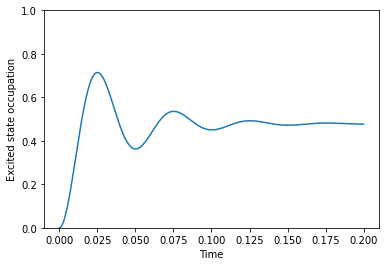

In [6]:
# Consider evolution including the effect of decoherence (Rabi flopping with decay)
sigma_ge= ket_g * bra_e
Gamma = 2*np.pi*6 # 1/s
decay_eg = np.sqrt(Gamma)*sigma_ge #e decays into g
result = mesolve(H, ket_g, t, [decay_eg], [sigma_ee])
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0])
ax.set_xlabel('Time')
ax.set_ylabel('Excited state occupation')
ax.set_ylim(0,1)
plt.show()

## Comparison to finite difference method

In [7]:
def solution(t, det, rabi, gamma):
    dt = t[1]-t[0]
    L = np.array([[0, 1], [0, 0]])
    Lt = np.array([[0, 0], [1, 0]])
    Pe = np.zeros(len(t))
    p = np.array([[1, 0], [0, 0]])
    for i in range(len(t)):
        H = np.array([[det, rabi/2], [rabi/2, 0]])
        p = (-1j * (np.dot(H, p) - np.dot(p, H)) + 
             gamma * (np.dot(L, np.dot(p, Lt)) 
                      - 0.5 * np.dot(Lt, np.dot(L, p)) 
                      - 0.5 * np.dot(p, np.dot(Lt, L)))) * dt + p
        Pe[i] = p[1, 1].real
    return(Pe)

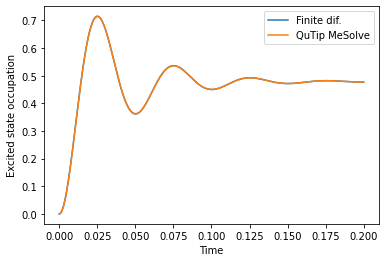

In [8]:
fig, ax = plt.subplots()
ax.plot(t, solution(t, 0, Rabi_freq, Gamma), label = "Finite dif.")
ax.plot(result.times, result.expect[0], label = "QuTip MeSolve")
ax.set_xlabel('Time')
ax.set_ylabel('Excited state occupation')
plt.legend()
plt.show()

## Three-level atoms with QuTip (time-independent H)

In [9]:
ket_g = basis(3, 0)
ket_e = basis(3,1)
ket_f = basis(3,2)

bra_g = ket_g.dag()
bra_e = ket_e.dag()
bra_f = ket_f.dag()

In [10]:
sig_gg = ket_g * bra_g
sig_ge = ket_g * bra_e
sig_gf = ket_g * bra_f
sig_eg = ket_e * bra_g
sig_ee = ket_e * bra_e
sig_ef = ket_e * bra_f
sig_fg = ket_f * bra_g
sig_fe = ket_f * bra_e
sig_ff = ket_f * bra_f

In [11]:
# define some Hamiltonian
Gamma = 2*np.pi*6
Rabi_ge = 5*Gamma
Rabi_ef = 5*Gamma
det_e = 0
det_f = 0
H = Rabi_ge/2 * (sig_eg + sig_ge) + Rabi_ef/2 * (sig_ef + sig_fe) - det_e*sig_ee - (det_e + 2*np.pi*det_f)*sig_ff
print(H)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.         94.24777961  0.        ]
 [94.24777961  0.         94.24777961]
 [ 0.         94.24777961  0.        ]]


In [12]:
decay_eg = np.sqrt(Gamma) * sig_ge  # e decays into g

In [13]:
print(sig_ee)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


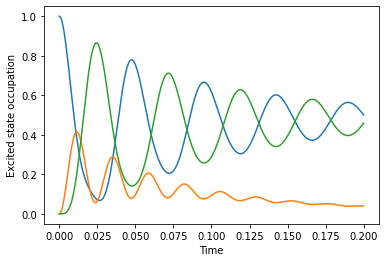

In [14]:
t2 = np.linspace(0,.2,5000)
result = mesolve(H, ket_g, t2, [decay_eg], [sig_gg, sig_ee, sig_ff])
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0])
ax.plot(result.times, result.expect[1])
ax.plot(result.times, result.expect[2])
ax.set_xlabel('Time')
ax.set_ylabel('Excited state occupation');
plt.show()

## Comparison to finite difference method

In [15]:
def solution3(t, det, rabi_ge, rabi_ef, gamma):
    dt = t[1]-t[0]
    L = np.array([[0, 1, 0], [0, 0, 0], [0, 0 , 0]])
    Lt = np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]])
    Pg = np.zeros(len(t))
    Pe = np.zeros(len(t))
    Pf = np.zeros(len(t))

    p = np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]])
    for i in range(len(t)):
        H = np.array([[det, rabi_ge/2, 0], [rabi_ge/2, 0, rabi_ef/2], [0, rabi_ef/2, 0]])
        p = (-1j * (np.dot(H, p) - np.dot(p, H)) + gamma * (np.dot(L, np.dot(p, Lt)) 
                                                            - 0.5 * np.dot(Lt, np.dot(L, p)) 
                                                            - 0.5 * np.dot(p, np.dot(Lt, L)))) * dt + p
        Pg[i] = p[0,0].real
        Pe[i] = p[1, 1].real
        Pf[i] = p[2,2].real
    return(Pg, Pe, Pf)

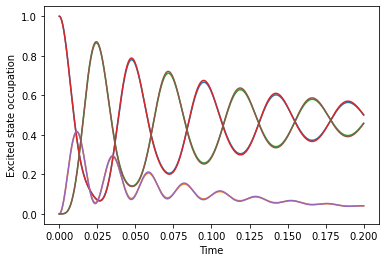

In [16]:
Pg, Pe, Pf = solution3(t2, 0, Rabi_ge, Rabi_ef, Gamma)
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0])
ax.plot(result.times, result.expect[1])
ax.plot(result.times, result.expect[2])
ax.plot(t2, Pg)
ax.plot(t2, Pe)
ax.plot(t2, Pf)

ax.set_xlabel('Time')
ax.set_ylabel('Excited state occupation');
plt.show()

## Two-level atom with qutip (time-dependent H)

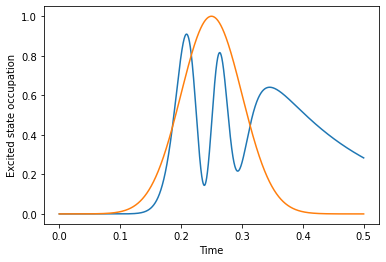

In [17]:
ket_g = basis(2, 0)
ket_e = basis(2,1)
bra_g = ket_g.dag()
bra_e = ket_e.dag()

# define the observable I care about
sigma_ee = ket_e * bra_e

# define some Hamiltonian
numt = int(1e5)
t = np.linspace(0,.5,numt)
Rabi_0 = 2*np.pi*20 # approximately a 2 pi pulse

def Rabi_freq_func(t, args):
    return Rabi_0*np.exp(-(t-0.25)**2/2/0.05**2)

H1 = sigmax()/2
H0 = 0*sigma_ee
H = [H0,[H1,Rabi_freq_func]]

# Consider evolution including the effect of decoherence (Rabi flopping with decay)
sigma_ge = ket_g * bra_e
Gamma = 6
decay_eg = np.sqrt(Gamma)*sigma_ge #e decays into g
result = mesolve(H, ket_g, t, [decay_eg], [sigma_ee])
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0])
ax.plot(t, Rabi_freq_func(t, 0)/max(Rabi_freq_func(t, 0)))
ax.set_xlabel('Time')
ax.set_ylabel('Excited state occupation');
plt.show()


## Comparison to finite difference method

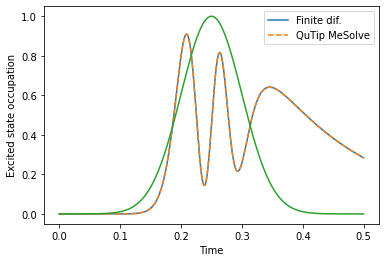

In [18]:
def solution_t(t, det, rabi, gamma):
    dt = t[1]-t[0]
    L = np.array([[0, 1], [0, 0]])
    Lt = np.array([[0, 0], [1, 0]])
    Pe = np.zeros(len(t))
    p = np.array([[1, 0], [0, 0]])
    for i in range(len(t)):
        H = np.array([[det, rabi[i]/2], [rabi[i]/2, 0]])
        p = (-1j * (np.dot(H, p) - np.dot(p, H)) + gamma * (np.dot(L, np.dot(p, Lt)) -
                                                            0.5 * np.dot(Lt, np.dot(L, p)) - 0.5 * np.dot(p, np.dot(Lt, L)))) * dt + p
        Pe[i] = p[1, 1].real
    return(Pe)

fig, ax = plt.subplots()
ax.plot(t, solution_t(t, 0, Rabi_freq_func(t, 0), Gamma), label = "Finite dif.")
ax.plot(result.times, result.expect[0], '--', label = "QuTip MeSolve")
ax.plot(t, Rabi_freq_func(t, 0)/max(Rabi_freq_func(t, 0)))
ax.set_xlabel('Time')
ax.set_ylabel('Excited state occupation')
plt.legend()
plt.show()

## STIRAP with QuTip (time-dependent H)

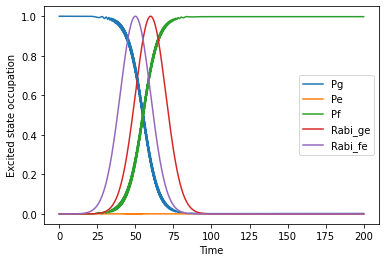

In [19]:
ket_g = basis(3, 0)
ket_e = basis(3,1)
ket_f = basis(3,2)

bra_g = ket_g.dag()
bra_e = ket_e.dag()
bra_f = ket_f.dag()

sig_gg = ket_g * bra_g
sig_ge = ket_g * bra_e
sig_gf = ket_g * bra_f
sig_eg = ket_e * bra_g
sig_ee = ket_e * bra_e
sig_ef = ket_e * bra_f
sig_fg = ket_f * bra_g
sig_fe = ket_f * bra_e
sig_ff = ket_f * bra_f

# define some Hamiltonian
Gamma = 2*np.pi*6
Rabi_ge = 500*Gamma
Rabi_ef = 500*Gamma
det_e = 0
det_f = 0


# define some Hamiltonian
numt = int(3e4)
t = np.linspace(0,0.2,numt)

t1 = 0.05
t2 = 0.06
duration = 0.01
def Rabi_freq_func1(t, args):
    return Rabi_ef*np.exp(-(t-t2)**2/2/duration**2)
def Rabi_freq_func2(t, args):
    return Rabi_ge*np.exp(-(t-t1)**2/2/duration**2)



H0 = - det_e*sig_ee - (det_e + det_f)*sig_ff
H1 = (sig_eg + sig_ge) 
H2 = (sig_ef + sig_fe)
H = [H0,[H1,Rabi_freq_func1], [H2,Rabi_freq_func2]]

# Consider evolution including the effect of decoherence (Rabi flopping with decay)
decay_eg = np.sqrt(Gamma)*sig_ge #e decays into g
result = mesolve(H, ket_g, t, [decay_eg], [sig_gg, sig_ee, sig_ff])
fig, ax = plt.subplots()
ax.plot(1000*result.times, result.expect[0], label = "Pg")
ax.plot(1000*result.times, result.expect[1], label = "Pe")
ax.plot(1000*result.times, result.expect[2], label = "Pf")
ax.plot(1000*t, Rabi_freq_func1(t, 0)/max(Rabi_freq_func1(t, 0)), label = "Rabi_ge")
ax.plot(1000*t, Rabi_freq_func2(t, 0)/max(Rabi_freq_func2(t, 0)), label = "Rabi_fe")
ax.set_xlabel('Time')
ax.set_ylabel('Excited state occupation')
plt.legend()
plt.show()




## Comparison to finite difference method

In [20]:
def ThreeLevelSolver(t, det_e, det_f, rabi_ge, rabi_ef, gamma):
    dt = t[1]-t[0]
    L = np.array([[0, 1, 0], [0, 0, 0], [0, 0 , 0]])
    Lt = np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]])
    Pg = np.zeros(len(t))
    Pe = np.zeros(len(t))
    Pf = np.zeros(len(t))

    p = np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]])
    for i in range(len(t)):
        H = np.array([[0, rabi_ge[i]/2, 0], [rabi_ge[i]/2, -det_e, rabi_ef[i]/2], [0, rabi_ef[i]/2, -det_e - det_f]])
        p = (-1j * (np.dot(H, p) - np.dot(p, H)) + gamma * (np.dot(L, np.dot(p, Lt)) 
                                                            - 0.5 * np.dot(Lt, np.dot(L, p)) 
                                                            - 0.5 * np.dot(p, np.dot(Lt, L)))) * dt + p
        Pg[i] = p[0,0].real
        Pe[i] = p[1, 1].real
        Pf[i] = p[2,2].real
    return(Pg, Pe, Pf)

In [37]:
def Compare(t):
    t1 = 0.05
    t2 = 0.06
    duration = 0.01
    def Rabi_freq_func1(t, args):
        return Rabi_ef*np.exp(-(t-t2)**2/2/duration**2)
    def Rabi_freq_func2(t, args):
        return Rabi_ge*np.exp(-(t-t1)**2/2/duration**2)
    H0 = - det_e*sig_ee - (det_e + det_f)*sig_ff
    H1 = (sig_eg + sig_ge) 
    H2 = (sig_ef + sig_fe)
    H = [H0,[H1,Rabi_freq_func1], [H2,Rabi_freq_func2]]
    starttime_qutip = time.time()
    result = mesolve(H, ket_g, t, [decay_eg], [sig_gg, sig_ee, sig_ff])
    stoptime_qutip = time.time()
    qutip_time = stoptime_qutip-starttime_qutip
    
    starttime_fd = time.time()
    Pg, Pe, Pf = ThreeLevelSolver(t, 0, 0, Rabi_freq_func1(t, 0), Rabi_freq_func2(t, 0), Gamma)
    stoptime_fd = time.time()
    fd_time = stoptime_fd-starttime_fd
    fig, ax = plt.subplots()
    ax.plot(1000*t, Pg, label = "Pg")
    ax.plot(1000*t, Pe, label = "Pe")
    ax.plot(1000*t, Pf, label = "Pf")
    ax.plot(1000*result.times, result.expect[0], '--')
    ax.plot(1000*result.times, result.expect[1], '--')
    ax.plot(1000*result.times, result.expect[2], '--')
    ax.plot(1000*t, Rabi_freq_func1(t, 0)/max(Rabi_freq_func1(t, 0)), label = "Rabi_ge(t)")
    ax.plot(1000*t, Rabi_freq_func2(t, 0)/max(Rabi_freq_func2(t, 0)), label = "Rabi_ef(t)")
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('State occupation')
    plt.legend()
    plt.show()
    print("QuTip time is %1.1f s" %qutip_time)
    print("Finite difference time is %1.1f s" %fd_time)
    return(result.expect[2][-1], Pf[-1])    

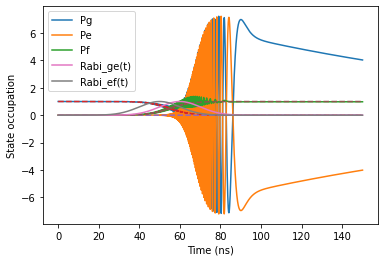

QuTip time is 1.6 s
Finite difference time is 2.4 s
(0.99787099279924, 0.9792848998314103)


In [38]:
numt = int(1e5)
t2 = np.linspace(0,0.15,numt)
print(Compare(t2))

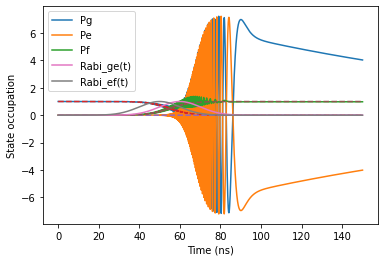

QuTip time is 1.6 s
Finite difference time is 2.5 s


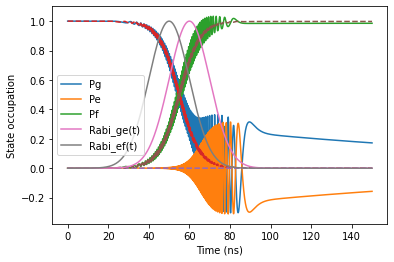

QuTip time is 2.3 s
Finite difference time is 3.7 s


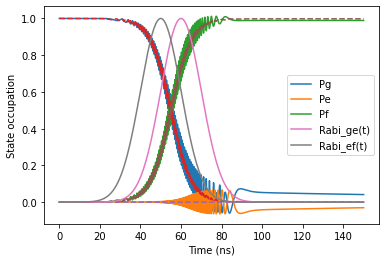

QuTip time is 3.0 s
Finite difference time is 5.0 s


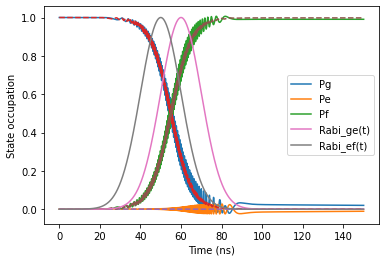

QuTip time is 3.9 s
Finite difference time is 6.3 s


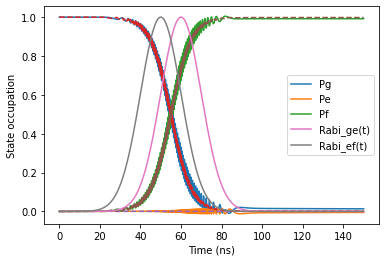

QuTip time is 4.3 s
Finite difference time is 7.7 s


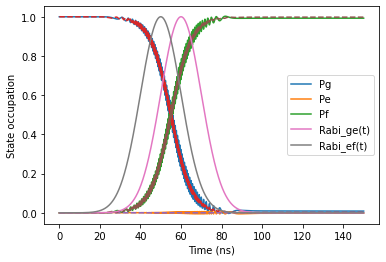

QuTip time is 5.9 s
Finite difference time is 10.1 s


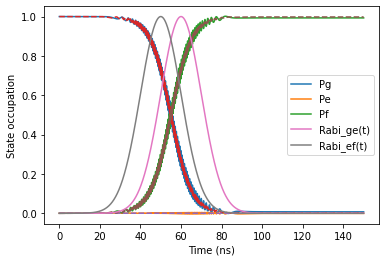

QuTip time is 7.1 s
Finite difference time is 12.4 s


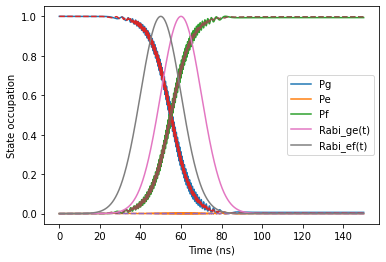

QuTip time is 10.0 s
Finite difference time is 17.0 s


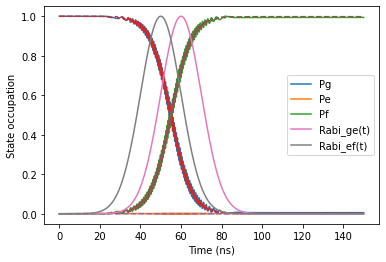

QuTip time is 14.0 s
Finite difference time is 26.0 s


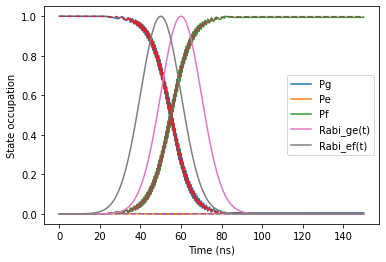

QuTip time is 40.1 s
Finite difference time is 70.0 s


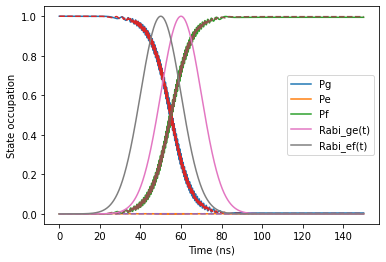

QuTip time is 100.2 s
Finite difference time is 178.6 s


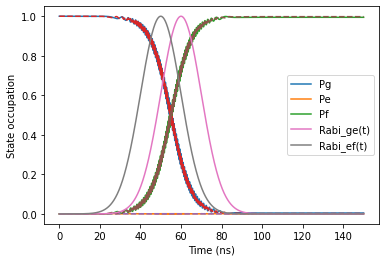

QuTip time is 137.3 s
Finite difference time is 233.0 s


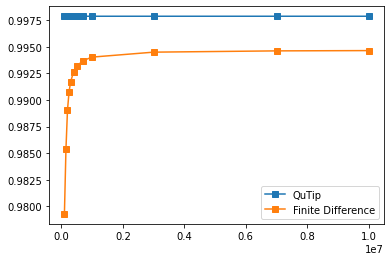

In [40]:
# Warning, this cell takes about 20 minutes to evaluate
numt = np.array([1e5,1.5e5, 2e5, 2.5e5, 3e5, 4e5, 5e5, 7e5, 1e6, 3e6, 7e6, 1e7])
numt = numt.astype(int)
numerical_errors_qutip = 0.0*numt
numerical_errors_fd = 0.0*numt
for i in range(len(numt)):
    t3 = np.linspace(0,0.15, numt[i])
    numerical_errors_qutip[i], numerical_errors_fd[i]  = Compare(t3) 

    
plt.figure()
plt.plot(numt, numerical_errors_qutip, '-s', label = "QuTip")
plt.plot(numt, numerical_errors_fd, '-s', label = "Finite Difference")
plt.legend()
plt.show()

Very interesting, so not only is QuTips mesolve slightly faster for the same time step size (~50%), but it also is much more immune to discretization errors, meaning that I can use timesteps 10-100x large without meaningful discretization errors. 

## Analyzing STIRAP

In [24]:
def STIRAP(t, duration, rabi0, Gamma, plot_bool): 
    Det_e = 0
    Det_f = 0
    t1 = np.mean(t)*2/3
    t2 = t1 + duration
    def Rabi_freq_func1(t, args):
        return rabi0*np.exp(-(t-t2)**2/2/duration**2)
    def Rabi_freq_func2(t, args):
        return rabi0*np.exp(-(t-t1)**2/2/duration**2)
    H0 = - Det_e*sig_ee - (Det_e + Det_f)*sig_ff
    H1 = (sig_eg + sig_ge)/2 
    H2 = (sig_ef + sig_fe)/2
    H = [H0,[H1,Rabi_freq_func1], [H2,Rabi_freq_func2]]
    
    result = mesolve(H, ket_g, t, [decay_eg], [sig_gg, sig_ee, sig_ff])

    Pg = result.expect[0]
    Pe = result.expect[1]
    Pf = result.expect[2]
    Fidelity = Pf[-1]
    NumScattered = ((t[-1]-t[0])/(0.026))*np.sum(Pe)/np.sum(Pe+Pg+Pf)
    if plot_bool == True: 
        fig, ax = plt.subplots()
        ax.plot(1000*t, Pg, label = "Pg")
        ax.plot(1000*t, Pe, label = "Pe")
        ax.plot(1000*t, Pf, label = "Pf")
        ax.plot(1000*t, Rabi_freq_func1(t, 0)/max(Rabi_freq_func1(t, 0)), label = "Rabi_ge(t)")
        ax.plot(1000*t, Rabi_freq_func2(t, 0)/max(Rabi_freq_func2(t, 0)), label = "Rabi_ef(t)")
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('State occupation')
        plt.legend()
        plt.show()
    return(Fidelity, NumScattered)

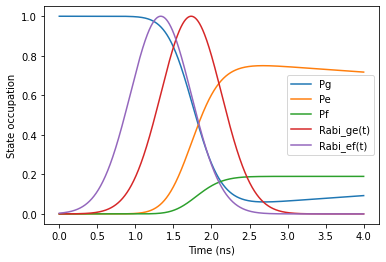

(0.18987785860310208, 0.06394176603378884)
Time for a Pi pulse is 0.00033


In [25]:
duration = 0.0004
dt = 1e-6
t2 = np.arange(0,10*duration,dt)
Gamma = 6
print(STIRAP(t2, duration, 500*Gamma,Gamma, True))
print("Time for a Pi pulse is %1.5f" %(1/(500*Gamma)))

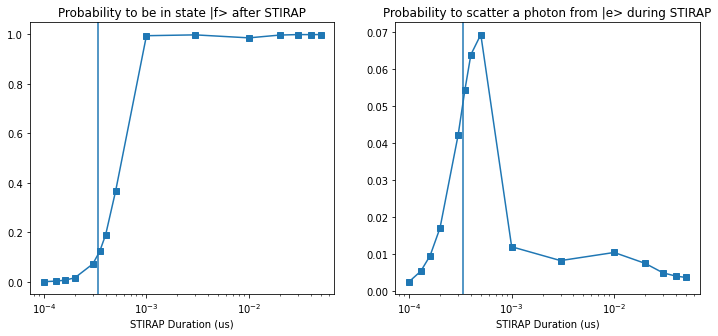

In [26]:
duration = np.array([0.0001, 0.00013, 0.00016, 0.0002, 0.0003, 0.00035, 0.0004, 0.0005, 0.001, 0.003, 0.01, 0.02, 0.03, 0.04, 0.05])
FinalFidelity = 0*duration
FinalProbScatter = 0*duration
Rabi = 500*Gamma
for i in range(len(duration)):
    dt = 1e-6
    t2 = np.arange(0,10*duration[i],dt)
    FinalFidelity[i], FinalProbScatter[i] = STIRAP(t2, duration[i], Rabi,Gamma, False)

    
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(duration,FinalFidelity, '-s')
ax[1].plot(duration,FinalProbScatter, '-s')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_title("Probability to be in state |f> after STIRAP")
ax[1].set_title("Probability to scatter a photon from |e> during STIRAP")
ax[0].text(0.5, 1e-3, "Rabi = %1.1f" %Rabi)
ax[0].set_xlabel("STIRAP Duration (us)")
ax[1].set_xlabel("STIRAP Duration (us)")
ax[0].axvline(1/Rabi)
ax[1].axvline(1/Rabi)

plt.show()

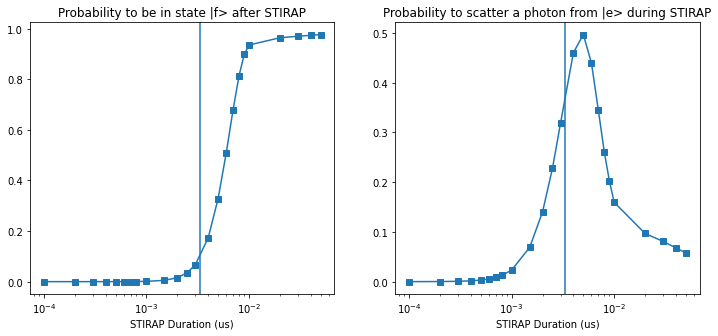

In [27]:
duration = np.array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05])
FinalFidelity = 0*duration
FinalProbScatter = 0*duration
Rabi = 50*Gamma
for i in range(len(duration)):
    dt = 1e-6
    t2 = np.arange(0,10*duration[i],dt)
    FinalFidelity[i], FinalProbScatter[i] = STIRAP(t2, duration[i], Rabi,Gamma, False)

    
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(duration,FinalFidelity, '-s')
ax[1].plot(duration,FinalProbScatter, '-s')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_title("Probability to be in state |f> after STIRAP")
ax[1].set_title("Probability to scatter a photon from |e> during STIRAP")
ax[0].text(0.5, 1e-3, "Rabi = %1.1f" %Rabi)
ax[0].set_xlabel("STIRAP Duration (us)")
ax[1].set_xlabel("STIRAP Duration (us)")
ax[0].axvline(1/Rabi)
ax[1].axvline(1/Rabi)
plt.show()

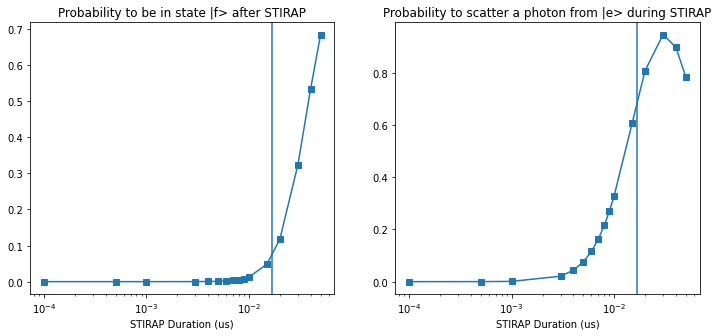

In [28]:
duration = np.array([0.0001, 0.0005, 0.001, 0.003, 0.004, 0.005,0.006, 0.007,0.008, 0.009, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05])
FinalFidelity = 0*duration
FinalProbScatter = 0*duration
Rabi = 10*Gamma
for i in range(len(duration)):
    dt = 1e-6
    t2 = np.arange(0,10*duration[i],dt)
    FinalFidelity[i], FinalProbScatter[i] = STIRAP(t2, duration[i], Rabi,Gamma, False)

    
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(duration,FinalFidelity, '-s')
ax[1].plot(duration,FinalProbScatter, '-s')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_title("Probability to be in state |f> after STIRAP")
ax[1].set_title("Probability to scatter a photon from |e> during STIRAP")
ax[0].text(0.5, 1e-3, "Rabi = %1.1f" %Rabi)
ax[0].set_xlabel("STIRAP Duration (us)")
ax[1].set_xlabel("STIRAP Duration (us)")
ax[0].axvline(1/Rabi)
ax[1].axvline(1/Rabi)
plt.show()